# Super resolution notebook
The slc data we want to use the super resolution on is stored in './data/slc_lr' and the denoised is stored in './data/denoised_lr' 

## Parameters to modify
- device : 'cuda' to use gpu, 'cpu' otherwise
- model_name : network to use for super resolution, choose between :
    - 'SWINTRANSFORMER'
    - 'SRCNN'
    - 'PixelShuffle'
- SR_type : super resolution method, choose between :
    - 'n_n' for noisy input to noisy output
    - 'n_d' for noisy input to denoised output
    - 'd_d' for denoised input to denoised output

In [34]:
device = 'cuda' # cuda or cpu
model_name = 'SWINTRANSFORMER' # SRCNN, PixelShuffle, SWINTRANSFORMER 
SR_type = 'n_d' # n_n, n_d or d_d 

## Run all these cells to make super resolution with the parameters chosed above

In [35]:
import os
import yaml
import argparse
import shutil
import pathlib
import torch
import sys
import numpy as np
from matplotlib import pyplot as plt
from utils import *

In [36]:
# load config
cfg = None
with open('./config_base.yaml', 'r') as y_file:
    cfg = yaml.load(y_file, Loader=yaml.FullLoader)
# load images path and normalization parameters
im_path,p_lr,p_hr = get_path_param(SR_type,cfg)
# load data
test_data = load_test(cfg,im_path,p_lr)
# load model
model = get_model(cfg,model_name,device)
if model_name.lower() != 'bicubic':
    load_path = os.path.join(cfg["INFERENCE"]["PATH_TO_WEIGHTS"],'{}_{}.pth'.format(model_name.lower(),SR_type))
    load_network(model, load_path, strict=True)
# save dir
save_path = os.path.join(cfg["INFERENCE"]["PATH_TO_SAVE"],'{}_{}'.format(model_name.lower(),SR_type))
os.makedirs(save_path,exist_ok=True)

print('{} network loaded'.format(model_name))
print('{} image(s) loaded'.format(len(test_data)))


SWINTRANSFORMER network loaded
1 image(s) loaded


In [37]:
denorm_hr = denormalizeSAR(p_hr[0],p_hr[1],p_hr[2])
denorm_lr = denormalizeSAR(p_lr[0],p_lr[1],p_lr[2])
with torch.no_grad():
    for image, filename in test_data:
        filename = filename[0]
        print('{} - {}'.format(filename, image.shape))
        out = inference(image,model,device,cfg)
        out = out.cpu().detach().numpy().squeeze()
        image = image.cpu().detach().numpy().squeeze()
        image, out = denorm_lr(image), denorm_hr(out)
        np.save(os.path.join(save_path,'{}_output.npy'.format(filename)),out)
        save_im(out,os.path.join(save_path,'{}_output.png'.format(filename)))
        np.save(os.path.join(save_path,'{}_input.npy'.format(filename)),image)
        save_im(image,os.path.join(save_path,'{}_input.png'.format(filename)))

lowres - torch.Size([1, 1, 256, 256])


## Results
The results are now stored in ./data/results/{model_name}_{SR_type}
The cell below display them, the image on the left is the input and the one on the right is the output

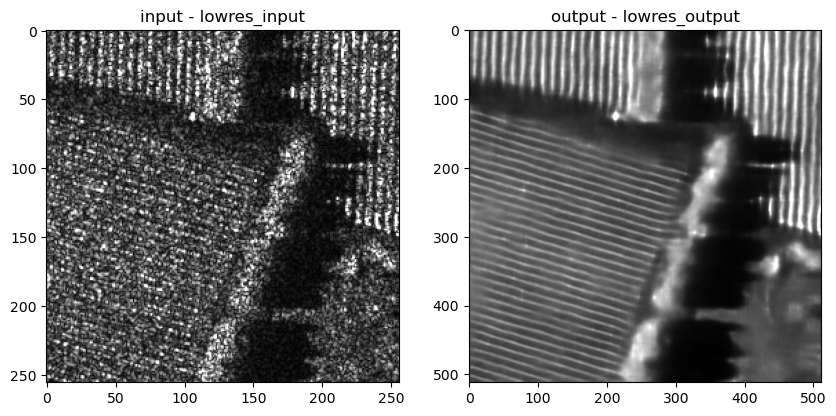

In [38]:
path_res = glob.glob(os.path.join(save_path,'*_output.npy'))
for p in path_res:
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    name = os.path.basename(p)
    name = os.path.splitext(name)[0]
    im_out = np.load(p)
    im_in = np.load(p.replace('_output','_input'))
    im_out,im_in = tresh_im(im_out),tresh_im(im_in)
    ax[0].imshow(im_in,cmap = 'gray')
    ax[1].imshow(im_out,cmap = 'gray')
    ax[0].set_title('input - {}'.format(name.replace('_output','_input')))
    ax[1].set_title('output - {}'.format(name))